## Stack Exchange

Stack Exchange hosts sites on a multitude of fields and subjects, including mathematics, physics, philosophy, and data science.
Stack Exchange employs a reputation award system for its questions and answers. Each post — each question/answer — is a post that is subject to upvotes and downvotes. This ensures that good posts are easily identifiable.
- What kind of questions are welcome on this site?
    - Almost any question possible, but there are some rules to consider. Mostly question of subjective matter are not allowed. E.g “What’s your favorite ______?”. More information can be found [here](https://stackoverflow.com/help/dont-ask)
- What, other than questions, does the site's [home](https://datascience.stackexchange.com/) subdivide into?
    - You can search for not only questions, but for Tags, Users and for Unanswered questions.
    
### Data

Stackexchange provides a Data Explorer called [Stack Exchange Data Explorer (SEDE)](https://data.stackexchange.com/help) and an interactive window to execute query's directly in [Stack's Exchange Database](https://data.stackexchange.com/datascience/query/new).

Most of the more informative columns are contained in the Table ``Posts``. In this table we can find columns like:
+ ``Id``: An identification number for the post.
+ ``PostTypeId``: An identification number for the type of post.(See Table Below!)
+ ``CreationDate``: The date and time of creation of the post.
+ ``Score``: The post's score.
+ ``ViewCount``: How many times the post was viewed.
+ ``Tags``: What tags were used.
+ ``AnswerCount``: How many answers the question got (only applicable to question posts).
+ ``FavoriteCount``: How many times the question was favored (only applicable to question posts).

PostTypes: 

| 1 | Question            |
|:---|:---------------------|
| 2 | Answer              |
| 3 | Wiki                |
| 4 | TagWikiExcerpt      |
| 5 | TagWiki             |
| 6 | ModeratorNomination |
| 7 | WikiPlaceholder     |
| 8 | PrivilegeWiki       |

The whole data is about 50.000 Rows!. Therefore we will only use data from the year 2019.

The following Query was used to fetch the respective data:
> Note: The ``CreationDate`` column was already of ``datetime`` class

```mysql
SELECT Id,
       PostTypeId,
       CreationDate,
       Score,
       ViewCount,
       Tags,
       AnswerCount,
       FavoriteCount
FROM Posts
WHERE YEAR(CreationDate) = 2019

```

Let's start with the analysis by importing some Python packages


In [1]:
import pandas as pd 
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the Data

questions_data = pd.read_csv("QueryResults_2019.csv", parse_dates = ["CreationDate"])

questions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16241 entries, 0 to 16240
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             16241 non-null  int64         
 1   PostTypeId     16241 non-null  int64         
 2   CreationDate   16241 non-null  datetime64[ns]
 3   Score          16241 non-null  int64         
 4   ViewCount      8283 non-null   float64       
 5   Tags           8283 non-null   object        
 6   AnswerCount    8283 non-null   float64       
 7   FavoriteCount  1500 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 1015.2+ KB


In [3]:
questions_data.head(10)

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,53162,1,2019-06-04 03:49:31,3,592.0,<machine-learning><loss-function>,3.0,1.0
1,53163,1,2019-06-04 04:05:24,0,24.0,<nlp><natural-language-process>,0.0,NaN
2,56617,2,2019-07-30 11:02:01,0,NaN,NaN,NaN,NaN
3,56618,2,2019-07-30 11:22:14,1,NaN,NaN,NaN,NaN
4,56620,1,2019-07-30 11:50:18,1,539.0,<python><nlp><word2vec><gensim><similar-docume...,0.0,NaN
5,56621,1,2019-07-30 12:14:59,1,77.0,<reinforcement-learning><q-learning><markov-pr...,1.0,NaN
6,56622,1,2019-07-30 12:29:59,1,114.0,<scikit-learn><clustering><k-means><unsupervis...,3.0,NaN
7,56623,2,2019-07-30 12:35:33,2,NaN,NaN,NaN,NaN
8,56624,1,2019-07-30 13:07:01,1,18.0,<reinforcement-learning><policy-gradients>,0.0,NaN
9,56625,2,2019-07-30 13:36:32,2,NaN,NaN,NaN,NaN


In [4]:
questions_data.isna().sum()

Id                   0
PostTypeId           0
CreationDate         0
Score                0
ViewCount         7958
Tags              7958
AnswerCount       7958
FavoriteCount    14741
dtype: int64

There are 7958 missing values on the ``View``, ``Tags`` and ``AnswerCount`` columns. A possible reason could be that, these posts had no answer due to the fact that they where closed, banned or simply where not a question. Therefore we need to check what kind of posts are more relevant for the analysis and investigate if just by choosing a specific post type the number of missing values can be reduced.

In [5]:
questions_data[questions_data["PostTypeId"] == 1].isna().sum()

Id                  0
PostTypeId          0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    6783
dtype: int64

By filtering the ``PostTypeId`` column, we can see that the number of missing values is reduced in all colums but in the Favorite count. This column just refers to How many times the question was favored. There is no reason to keep that column with missign values and as an float, we will change this also. We can conclude that if the aim is just to analyze the questions posts, then the data is clean enough. One last annotation in the way the format of the ``Tags`` was provided, in order to work more easily with these column we could convert rows with multiple tags to lists.
The idea is to go from:
```python
"<machine-learning><regression><linear-regression><regularization>"
```
to

```python
[machine-learning,regression,linear-regression,regularization]
```

In [6]:
questions_data = questions_data[questions_data["PostTypeId"] == 1]

# Generate a column of iterable lists
questions_data["Tags"] = (questions_data["Tags"]
                          .str.replace("><", ",")
                          .str.replace("<", "")
                          .str.replace(">", "")
                          .str.split(","))

In [7]:
# Fill missing values and transform the last column from float to  int
questions_data.fillna(value={"FavoriteCount":0}, inplace=True)
questions_data["FavoriteCount"] = questions_data["FavoriteCount"].astype(int)

In [8]:
questions_data.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,53162,1,2019-06-04 03:49:31,3,592.0,"[machine-learning, loss-function]",3.0,1
1,53163,1,2019-06-04 04:05:24,0,24.0,"[nlp, natural-language-process]",0.0,0
4,56620,1,2019-07-30 11:50:18,1,539.0,"[python, nlp, word2vec, gensim, similar-docume...",0.0,0
5,56621,1,2019-07-30 12:14:59,1,77.0,"[reinforcement-learning, q-learning, markov-pr...",1.0,0
6,56622,1,2019-07-30 12:29:59,1,114.0,"[scikit-learn, clustering, k-means, unsupervis...",3.0,0


## Most Used and Most Viewed

We want to know how popular some tags are in the dataset. Therefore we can count the number of times unique Tags appear on all questions and visualize these in order to get a clearer picture of the situation.

   > **Note! I decided for this project to use not the dataset provided, but to use data downloaded directly from the database on the 18.05.2020. Altough the data is also from 2019,  the number of Views in `` ViewCount``, ``AnswerCount`` and the ``Score`` may change since all the posts here are still avaliable to the public to be visited everyday. So results may vary significantly** 


In [28]:
# We can create a empy dictionary that acts as a frecuency table, and loop trough the all rows an their respective lists
# save this to a dictionay
frecuency_table = {}

for tags in questions_data.Tags:
    for tag in tags:
        if tag in frecuency_table:
            frecuency_table[tag]+=1
        else:
            frecuency_table[tag] = 1
        

In [29]:
# To work more easily with the data, we can create a dataframe from the dictionary

Tags = pd.DataFrame.from_dict(frecuency_table, orient='index')
Tags.rename(columns={0:"Count"}, inplace = True)
Tags = Tags.sort_values(by="Count", ascending=False)
Tags.head()

,Count
machine-learning,2544
python,1709
deep-learning,1134
neural-network,1005
keras,876


<AxesSubplot:>

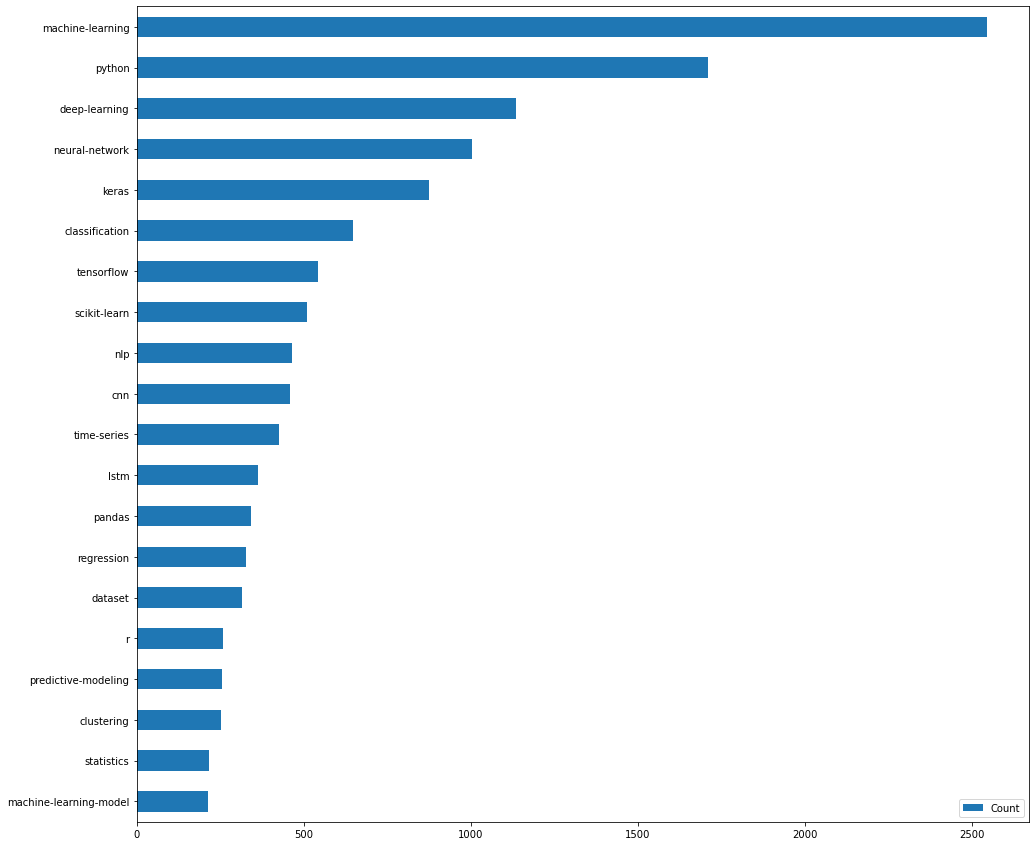

In [32]:
Tags.head(20).iloc[::-1].plot.barh(figsize=(16,15))

From the bar plot above we can see that the tags `machine-learning`, `python`, `deep-learning`, `neuronal-network` and `keras` are most used and popular tags in the dataset. This tells us that there are more posts containing the tag `machine-learning` than there for `python`. This can be a misleading indicator of interest and popularity, since there could be more posts related to machine learning topics than there is about python. But more importantly is the number of views those posts had. E.g. there could be posts about machine learning that might be duplicates or that contain very specific questions about one specific problem, whereas python as a programming language might have questions related to some functionality or library of python that more people might find useful. To answer this question we need to take into accounf the number of views each post had for each tag. 

In [33]:
view_frecuency = {}
for tag, view in zip(questions_data.Tags, questions_data.ViewCount):
    for i in tag:
        if i in view_frecuency:
            view_frecuency[i] += view
        else:
            view_frecuency[i] = view

In [34]:
Tag_view_freq = pd.DataFrame.from_dict(view_frecuency, orient='index')
Tag_view_freq.rename(columns={0:"Count"}, inplace = True)
Tag_view_freq = Tag_view_freq.sort_values(by="Count", ascending=False)
Tag_view_freq.head()

,Count
python,1036280.0
machine-learning,679138.0
keras,474111.0
pandas,448866.0
deep-learning,397576.0


<AxesSubplot:>

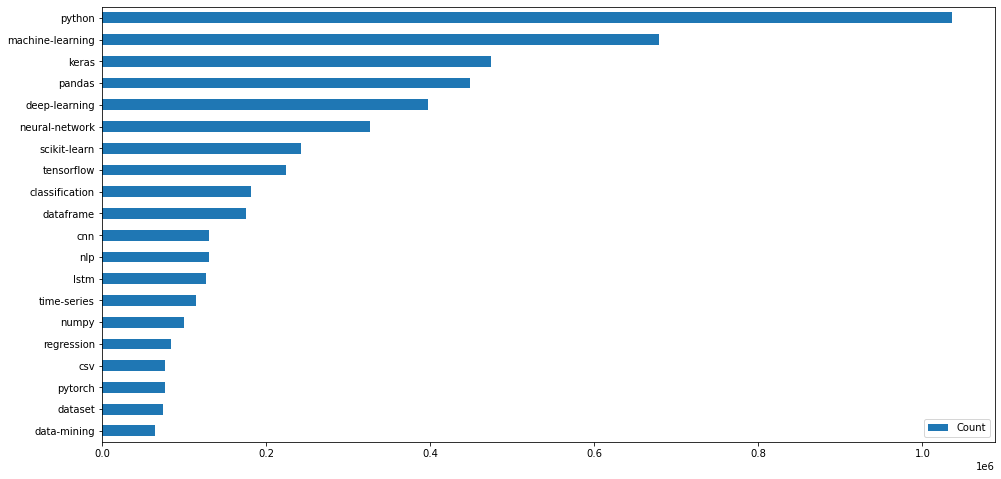

In [14]:
Tag_view_freq.head(20).iloc[::-1].plot.barh(figsize=(16,8))

On the graph we can observe that the rating now changed with tags like `machine-learning`, `python` and `keras` still at the top. In this case `python` has posts with significantly more views, which makes it a more popular topic for people to search for answers. One interesting thing that can be observed is that a new tag `pandas` made it into the top 5, which in the last plot was way down in the ranking (place 13). Since pandas is just a library for python, there is a chance that there are fewer questions asked since the library has some specific purposes where its used. But from the number of post views is clear that pandas play a significant role in the machine-learning/Data Science space, since it's an essential library for data manipulation. 

# Analyzing at the popularity increase of Deep Learning over the years

Here we want to take a specific topic in Data Science and analyze the popularity increase over the years. First we will read all the data instead of only the posts related to Data Science. This includes topics like other programming languages of CS related questions. 

In [15]:
all_questions = pd.read_csv("all_questions.csv",  parse_dates = ["CreationDate"])


all_questions["Tags"] = (all_questions["Tags"]
                          .str.replace("><", ",")
                          .str.replace("<", "")
                          .str.replace(">", "")
                          .str.split(","))


Here we make a list of tags related to deep learning and select data based on those.

In [16]:
DL_category = ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]

def class_deep_learning(tags):
    for tag in tags:
        if tag in DL_category:
            return 1
    return 0

In [17]:
# All deep learning questions

DL_questions = all_questions.copy()
DL_questions["DL_question"] = DL_questions["Tags"].apply(class_deep_learning)

DL_questions.head()
# DL_questions = pd.DataFrame(DL_questions.resample("3M", on="CreationDate").size(), columns=["Count"]).reset_index()
# DL_questions.head()

,Id,CreationDate,Tags,DL_question
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1
1,45418,2019-02-12 00:50:39,[neural-network],1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0
3,45426,2019-02-12 04:51:49,[keras],1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0


To add more granularity to the results. Instead of analyzing year by year, we set the time intervals to quarters.

In [18]:
def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(round(datetime.month/3))
    return "{y}Q{q}".format(y=year, q=quarter)


DL_questions["Q"] = DL_questions["CreationDate"].apply(fetch_quarter)

DL_questions.head()
# Here is a vectorized way of doing it.but without the "Q" in the middle of the string 
# (resample_df["CreationDate"].dt.year.astype(str)) + resample_df["CreationDate"].dt.month.divide(3).round().astype(int).astype(str)

,Id,CreationDate,Tags,DL_question,Q
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1,19Q1
1,45418,2019-02-12 00:50:39,[neural-network],1,19Q1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0,19Q1
3,45426,2019-02-12 04:51:49,[keras],1,19Q1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0,19Q1


We now aggregate the results for each quarter and create a new feature called Rate. This metric shows the percentage of questions related to deep-learning out of the total number of questions for that specific quarter. In other words, this metric will show the rate of increase or decrease in popularity over time. 

In [36]:
Summary = DL_questions.groupby("Q").agg({"DL_question":["sum", "size"]}).copy()
Summary.columns = ["Deep_learning_questions", "Total_questions"]
Summary["Rate"] = Summary["Deep_learning_questions"]/Summary["Total_questions"]
Summary.reset_index(inplace = True)
Summary.head()

,Q,Deep_learning_questions,Total_questions,Rate
0,14Q2,16,233,0.068670
1,14Q3,13,184,0.070652
2,14Q4,14,145,0.096552
3,15Q0,4,63,0.063492
4,15Q1,20,198,0.101010


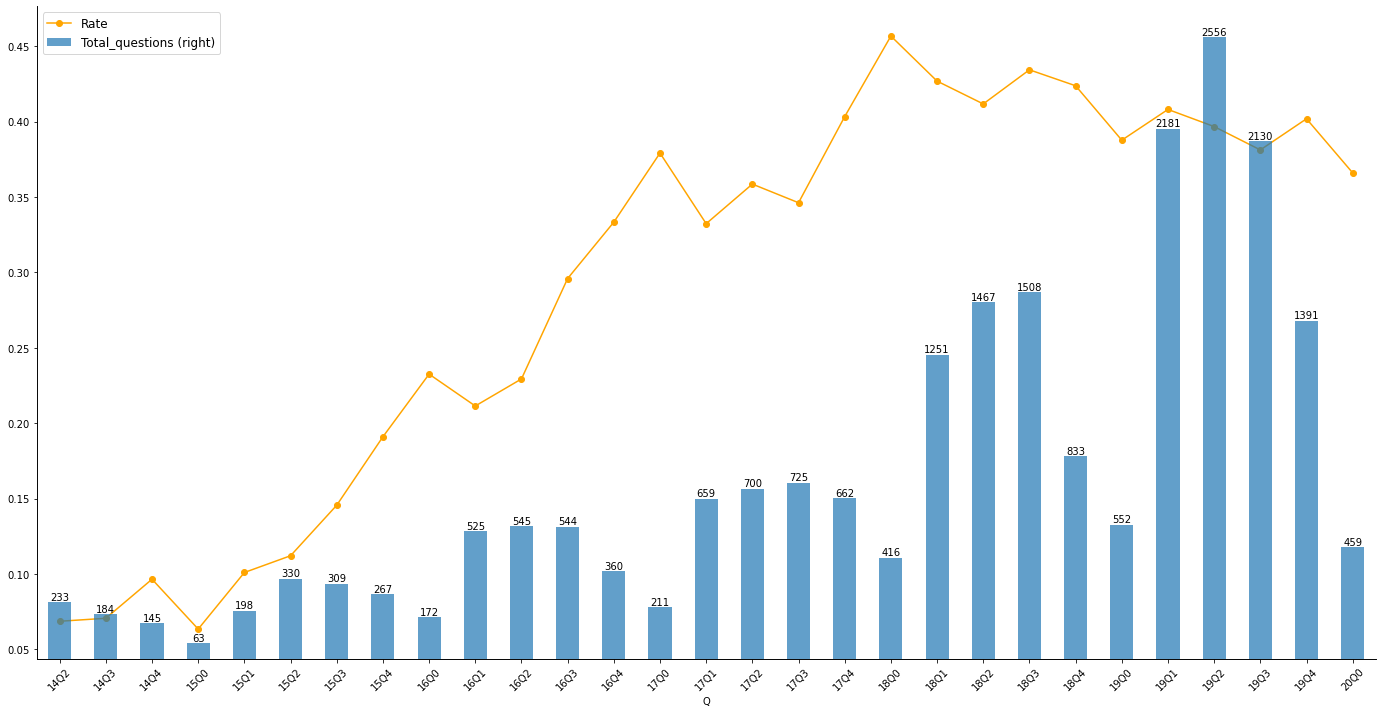

In [37]:
ax1 = Summary.plot(x="Q", y="Rate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = Summary.plot(x="Q", y="Total_questions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in enumerate(Summary["Total_questions"]):
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

The graph shows a bar plot for each quarter with the number of questions posted in the platform. The line plot is the rate metric over time. The first thing that can be observed is that the number of questions asked show a seasonality trend. In most of the years the number of questions increases between the second and third quarters. A possible explanation could be that people asking questions or learning about some topics might have been students of some kind. At the beginning of the year and at the end of the year, most of the students will be on brake or have finished the semester studies for which Stack Overflow was used to answer questions related to projects. This logic can also apply for people in the industry which go on vacation or just finished their yearly goals.  

The diagram also shows a clear increase in popularity of Stack Overflow as a platform. The number of questions asked increases over the years. Taking a look at our rate metric we can see that topics related to deep learning increased in popularity, to the point where almost 50% of all posts in year 2019 where related to Deep Learning. This increase in popularity can be also seen in the history of Deep Learning. This [article](https://en.wikipedia.org/wiki/Deep_learning#History) from Wikipedia about Deep-Learning show that by 2019 The Turing Award ([...] is the highest distinction in computer science and is known as or often referred to as "Nobel Prize of Computing".[...]) was awarded in March 2019, to Yoshua Bengio, Geoffrey Hinton and Yann LeCun for conceptual and engineering breakthroughs that have made deep neural networks a critical component of computing. By that time the usage of deep learning exploded in popularity. 